# Analyzing reuse of posters

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import unquote
import re
import os
import json

## Helper functions for citation count

In [68]:
_DOI_PATTERN = re.compile(
    r"""
    (?P<doi>                                  # capture group "doi"
        10\.\d{4,9}                           # directory indicator: 10.<4-9 digits>
        /                                     # slash
        [^\s"'<>\]]+                          # suffix: anything except whitespace/quotes/brackets
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

# Normalize dois, makes it easier to deduplicate citations
def _norm_doi(s):
    
    if not isinstance(s, str):
        return ""

    # Strip whitespace and decode any %-escapes first (handles %2F etc.)
    s_clean = unquote(s.strip())
    if not s_clean:
        return ""

    # Work in lowercase for stable matching
    s_lower = s_clean.lower()
    
    # Search for a DOI substring anywhere in the string
    m = _DOI_PATTERN.search(s_lower)
    if not m:
        return ""

    doi = m.group("doi").strip()

    return doi

# Get normalized doi url
def _norm_doi_url(s):
    doi_id = _norm_doi(s)
    if not doi_id:
        return ""
    return f"https://doi.org/{doi_id}"

#get OA record given DOI:
def get_oa_record(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    work_lookup = f"https://api.openalex.org/works/{_norm_doi_url(target_doi)}"
    if email:
        work_lookup += f"?mailto={email}"
    r = requests.get(work_lookup, timeout=60)
    r.raise_for_status()   # raise on ANY HTTP error

    record = r.json()
    return record


# Get citations given an OA id
def get_all_citing_works_oa(openalex_id, email=None):
    results = []
    cursor = "*"

    while True:
        url = f"https://api.openalex.org/works?filter=cites:{openalex_id}&per-page=200&cursor={cursor}"
        if email:
            url += f"&mailto={email}"

        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
        except requests.Timeout:
            raise

        data = r.json()
        results.extend(data["results"])

        cursor = data["meta"]["next_cursor"]
        if not cursor:
            break

    return results

# Get OA citations given a DOI
def find_citations_oa(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")

    record = get_oa_record(doi, email, api_key)

    try:
        openalex_id_url = record["id"]
        cited_by_count = record["cited_by_count"]
    except KeyError as e:
        raise KeyError(f"Missing expected OpenAlex field: {e}") from e

    if not cited_by_count:
        return []  # no citations

    if not isinstance(openalex_id_url, str) or "/" not in openalex_id_url:
        raise ValueError(f"Malformed OpenAlex id: {openalex_id_url}")

    openalex_id = openalex_id_url.rsplit("/", 1)[-1]

    # Get all citing works
    citing_records = get_all_citing_works_oa(openalex_id, email=email)

    results = []
    for c in citing_records:
        doi_raw = c.get("doi") or ""
        citation_link = _norm_doi_url(doi_raw) or c.get("id", "")

        citation_date_raw = c.get("publication_date") or ""
        try:
            citation_year = int(citation_date_raw[:4]) if citation_date_raw else ""       
        except (ValueError, TypeError):
            citation_year = ""

        if citation_link:
            rec = {
                "poster_doi": doi,
                "source": ["openalex"],
                "citation_link": citation_link,
            }
            if citation_year:
                rec["citation_year"] = citation_year
            results.append(rec)

    return results

# Get DataCite record for a doi
def get_datacite_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    url = f"https://api.datacite.org/dois/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()
    return record
    
# Get citation list from Datacite
def find_citations_datacite(doi, timeout = 30):    
    record  = get_datacite_record(doi, timeout)
    citations = (
    record.get("data", {})
          .get("relationships", {})
          .get("citations", {})
          .get("data", [])
    )
    
    results = []
    for item in citations:
        citation_id = item["id"]
        citation_link = _norm_doi_url(citation_id) or citation_id
        rec = {
            "poster_doi": doi,
            "source": ["datacite"],
            "citation_link": citation_link,
        }
        results.append(rec)
    
    return results

def get_crossref_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")    
    url = f"https://api.crossref.org/works/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()   
    return record

# Get publication year
def get_publication_year(doi, email = None, api_key = None):
    
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}") 
        
    # Try OA first
    try:
        record = get_oa_record(target_doi, email=email, api_key=api_key)
        pub_date = record.get("publication_date")
        if pub_date and len(pub_date) >= 4:
            return int(pub_date[:4])
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Then try CrossRef
    try:
        record = get_crossref_record(target_doi)
        year = record["data"]["attributes"].get("publicationYear")
        if year:
            return int(year)
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Finally try DataCite
    try:
        record = get_datacite_record(target_doi)
        year = record_cf["message"]["created"]["date-parts"][0][0]
        if year:
            return int(year)
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    
    return ""

def find_citations(doi, email=None, api_key=None):
        
    # 1) OA 
    try:
        results_oa = find_citations_oa(doi, email, api_key)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_oa = [] #(404 => no OA record => no OA citations)
        else:
            raise  # real OA error

    # 2) DataCite 
    try:
        results_dc = find_citations_datacite(doi)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_dc = [] #(404 => no DC record => no DC citations)
        else:
            raise  # real DC error
            
    # 3) Deduplicate OA results + index for fast deduplication
    results = []
    index = {}

    for rec in results_oa:
        link = rec.get("citation_link")
        key = link

        # keep on first occurrence in case there are duplicated in oa citations list
        if key in index:
            continue
        index[key] = len(results)
        results.append(rec)

    # 4) Add DataCite citations
    for dc in results_dc:
        link = dc.get("citation_link")
        key = link

        if key in index:
            # already exists: then add datacite to "source" list
            i = index[key]
            results[i]["source"] = sorted(set(results[i]["source"]) | {"datacite"}) #makes sure datacite only added once even if the citation is duplicated in the datacite list
            continue

        # new citation from DataCite
        new_rec = {
            "poster_doi": dc.get("poster_doi"),
            "source": ["datacite"],
            "citation_link": link,
        }

        # if it's a DOI, try OA lookup for year
        if _norm_doi(link):
            year = get_publication_year(link, email, api_key)
            if year:
                new_rec["citation_year"] = year

        index[key] = len(results)
        results.append(new_rec)
    
    return results

# load completed DOIs
def _load_done_set(done_path):
    done = set()
    if not os.path.exists(done_path):
        return done
    with open(done_path, "r", encoding="utf-8") as f:
        for line in f:
            d = line.strip()
            if d:
                done.add(d)
    return done

# save completed DOIs
def _append_done(done_path, doi):
    os.makedirs(os.path.dirname(done_path), exist_ok=True)

    with open(done_path, "a", encoding="utf-8") as f:
        f.write(doi + "\n")
        f.flush()
        os.fsync(f.fileno())

# save citation results to file
def _append_ndjson(path, records):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    n = 0
    with open(path, "a", encoding="utf-8") as f:
        for rec in records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            n += 1
        f.flush()
        os.fsync(f.fileno())
    return n

def run_find_citations_for_df(
    df,
    *,
    doi_col,
    out_ndjson,
    done_path,
    error_ndjson,
    email = None,
    api_key = None,
    normalize_done_key = False,
) -> dict:
    """
    Runs find_citations() for every DOI in df[doi_col], appends all citation records
    to out_ndjson, and records successfully processed DOIs in done_path so you can resume.

    - Skips missing/blank/NaN DOIs.
    - Skips DOIs already in done_path.
    - Logs failures to error_ndjson and continues.
    """
    if doi_col not in df.columns:
        raise KeyError(f"Missing column '{doi_col}' in df")

    done = _load_done_set(done_path)

    total = 0
    skipped_missing = 0
    skipped_done = 0
    succeeded = 0
    failed = 0
    written = 0

    for raw in df["doi"]:
        doi = _norm_doi(raw)
        if not doi:
            skipped_missing += 1
            continue

        done_key = doi   # <-- define it here, always

        if done_key in done:
            skipped_done += 1
            continue

        try:
            records = find_citations(doi, email=email, api_key=api_key) or []
            written += _append_ndjson(out_ndjson, records)
            _append_done(done_path, done_key)
            done.add(done_key)
            succeeded += 1

        except Exception as e:
            failed += 1
            err_rec = {
                "poster_doi": raw,
                "poster_doi_norm": done_key,
                "error_type": type(e).__name__,
                "error": str(e),
            }
            _append_ndjson(error_ndjson, [err_rec])
            
        msg = (
            f"\r{succeeded + failed}/{len(df)} DOIs completed | "
            f"found {written} citations | "
            f"{failed} DOIs failed"
        )
        print(msg, end="", flush=True)
    
    return {
        "total_rows": total,
        "skipped_missing_doi": skipped_missing,
        "skipped_already_done": skipped_done,
        "succeeded_dois": succeeded,
        "failed_dois": failed,
        "citation_records_written": written,
        "out_ndjson": out_ndjson,
        "done_path": done_path,
        "error_ndjson": error_ndjson,
    }

## Collect citation data

### Import data

In [2]:
df = pd.read_csv("inputs/dataset/derivative/poster-metadata/posters-metadata.csv")
df.head(5)

C:\Users\BPatel\AppData\Local\Temp\ipykernel_17144\1611734530.py:1: DtypeWarning: Columns (14,17,20,21,22,23,24,25,26,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("inputs/dataset/derivative/poster-metadata/posters-metadata.csv")


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,references_with_identifiers_count,has_title,has_version,has_description,description_number_words,files,views,downloads,repository,description_number_characters
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,0,True,False,True,348.0,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo,NaN
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,0,True,False,True,116.0,17_Poster.pdf,72,149,Zenodo,NaN
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,0,True,False,True,226.0,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo,NaN
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,0,True,False,True,143.0,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo,NaN
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,0,True,False,True,115.0,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo,NaN


### Get citations from OpenAlex and DataCite for posters with DOI

In [69]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
done_path = "outputs/citations/posters-citations.done.txt"
error_ndjson = "outputs/citations/posters-citations.errors.ndjson"

summary = run_find_citations_for_df(
    df,
    doi_col = "doi",
    out_ndjson = out_ndjson,
    done_path = done_path,
    error_ndjson = error_ndjson,
    email = "bpatel@calmi2.org"    
)
display(summary)

34316/39132 DOIs completed | found 17716 citations | 0 DOIs failed

{'total_rows': 0,
 'skipped_missing_doi': 570,
 'skipped_already_done': 4246,
 'succeeded_dois': 34316,
 'failed_dois': 0,
 'citation_records_written': 17716,
 'out_ndjson': 'outputs/citations/posters-citations.ndjson',
 'done_path': 'outputs/citations/posters-citations.done.txt',
 'error_ndjson': 'outputs/citations/posters-citations.errors.ndjson'}

### Add citation to metadata table

## Analyze engagement (views, downloads, and citations)

### Import data

In [4]:
df1 = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df2 = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")
df1["repository"] = "Zenodo"
df2["repository"] = "Figshare"

In [10]:
df = pd.concat([df1, df2], ignore_index=True)
df = df[
    (df["views"].notna()) &
    (df["downloads"].notna()) &
    (df["views"] >= 0) &
    (df["downloads"] >= 0)
]
display(df)

,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,other_dates,references_no_identifiers_count,references_with_identifiers_count,has_title,has_version,has_description,files,views,downloads,repository
0,10.5281/zenodo.4407772,https://doi.org/10.5281/zenodo.4407772,https://zenodo.org/records/4407772,True,3,3,0,0,0,3,...,NaN,0,0,True,False,True,idisba2020_poster_30x40_Yao_Ortiz_Bonnin.pdf,125,73,Zenodo
1,10.5281/zenodo.4405835,https://doi.org/10.5281/zenodo.4405835,https://zenodo.org/records/4405835,True,5,5,0,0,0,5,...,NaN,0,0,True,False,True,17_Poster.pdf,72,149,Zenodo
2,10.5281/zenodo.4404729,https://doi.org/10.5281/zenodo.4404729,https://zenodo.org/records/4404729,True,7,0,0,0,0,7,...,NaN,0,0,True,False,True,x.f Lebanon 24.04.2019 raied (2).pdf,77,58,Zenodo
3,10.5281/zenodo.4402107,https://doi.org/10.5281/zenodo.4402107,https://zenodo.org/records/4402107,True,1,0,0,0,0,1,...,NaN,0,0,True,False,True,A_Chatterjee_PMT_ICARUS.mp4; AC_PMT_Poster_Neu...,120,108,Zenodo
4,10.5281/zenodo.4401815,https://doi.org/10.5281/zenodo.4401815,https://zenodo.org/records/4401815,True,3,0,0,0,0,3,...,NaN,0,0,True,False,True,Final_Zara_Bagdarian_Borexino_Spectral_Fit_238...,147,75,Zenodo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39127,10.6084/m9.figshare.25792542.v1,https://doi.org/10.6084/m9.figshare.25792542.v1,https://figshare.com/articles/poster/Investiga...,True,4,-1,-1,-1,-1,4,...,NaN,-1,0,True,True,True,DSD24Poster_final.pdf,587,20,Figshare
39128,10.6084/m9.figshare.24804966.v1,https://doi.org/10.6084/m9.figshare.24804966.v1,https://figshare.com/articles/poster/MBSJ2023_...,True,1,-1,-1,-1,-1,1,...,NaN,-1,0,True,True,True,231205_分子生物学会ポスター_ver3_yonezawa.pdf,292,44,Figshare
39129,NaN,https://doi.org/,https://repository.lincoln.ac.uk/articles/post...,True,3,-1,-1,-1,-1,3,...,NaN,-1,0,True,True,True,SEAHA%20poster%20FINAL%20%28300dpi%29.jpg,0,0,Figshare
39130,NaN,https://doi.org/,https://repository.lincoln.ac.uk/articles/post...,True,3,-1,-1,-1,-1,3,...,NaN,-1,0,True,True,True,NaN,0,0,Figshare


### Analysis

#### Distribution table

In [33]:
def summarize_distribution(df, col: str):
    return pd.Series({
        "count": df[col].count(),
        "mean": df[col].mean(),
        "median": df[col].median(),
        "std": df[col].std(),
        "min": df[col].min(),
        "p25": df[col].quantile(0.25),
        "p75": df[col].quantile(0.75),
        "p90": df[col].quantile(0.90),
        "p95": df[col].quantile(0.95),
        "max": df[col].max(),
    })

def top_share(df, col: str, top_pct: float) -> float:
    total = df[col].sum()
    cutoff = df[col].quantile(1 - top_pct)
    return df.loc[df[col] >= cutoff, col].sum() / total

summary = pd.DataFrame({
    "views": summarize_distribution(df, "views"),
    "downloads": summarize_distribution(df, "downloads"),
})

# Add concentration rows
for pct in [0.01, 0.05, 0.10]:
    label = f"top_{int(pct*100)}%_share"
    summary.loc[label, "views"] = top_share(df, "views", pct) * 100
    summary.loc[label, "downloads"] = top_share(df, "downloads", pct) * 100

# Round everything
summary_int = summary.round(0).astype(int)

print(summary_int)

                views  downloads
count           39132      39132
mean              233        106
median             84         52
std               897        235
min                 0          0
p25                40         22
p75               216        112
p90               583        259
p95               875        396
max            132859      18508
top_1%_share       18         14
top_5%_share       39         33
top_10%_share      54         48


#### Distribution plots

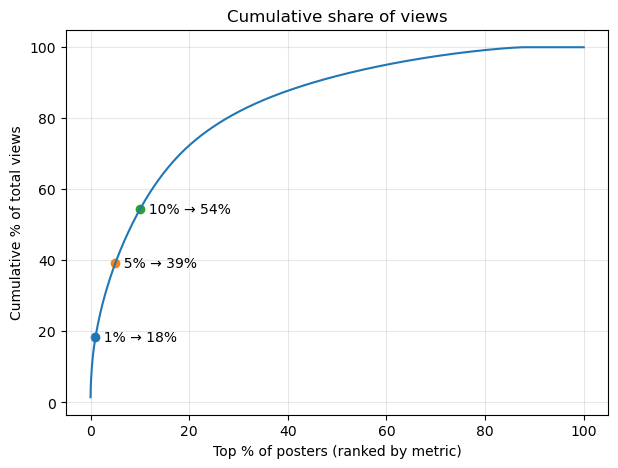

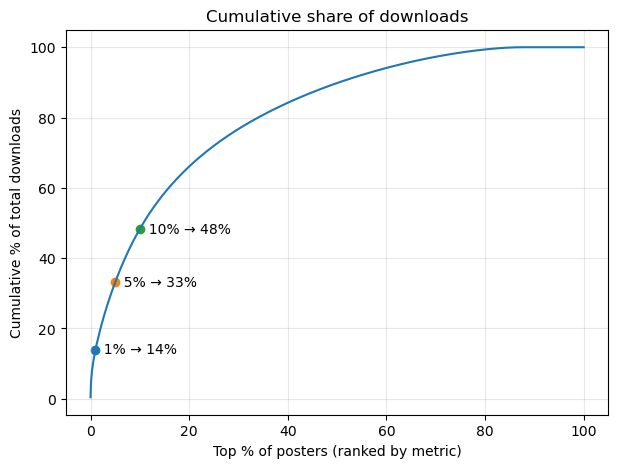

In [41]:
def plot_cumulative_share(df: pd.DataFrame, col: str, title: str | None = None):
    x = df[col].fillna(0).clip(lower=0).to_numpy()
    x_sorted = np.sort(x)[::-1]  # descending
    cum_share = np.cumsum(x_sorted) / x_sorted.sum()
    top_pct = np.arange(1, len(x_sorted) + 1) / len(x_sorted)  # 0..1

    plt.figure(figsize=(7, 5))
    plt.plot(top_pct * 100, cum_share * 100)
    plt.xlabel("Top % of posters (ranked by metric)")
    plt.ylabel(f"Cumulative % of total {col}")
    plt.title(title or f"Cumulative share of {col} by top posters")
    plt.grid(True, alpha=0.3)
    plt.show()

def annotate_top_points(df, col: str, points=(1, 5, 10)):
    x = df[col].fillna(0).clip(lower=0).to_numpy()
    x_sorted = np.sort(x)[::-1]
    cum_share = np.cumsum(x_sorted) / x_sorted.sum()
    top_pct = np.arange(1, len(x_sorted) + 1) / len(x_sorted)

    plt.figure(figsize=(7, 5))
    plt.plot(top_pct * 100, cum_share * 100)
    for p in points:
        idx = int(np.ceil(len(x_sorted) * (p / 100))) - 1
        plt.scatter([p], [cum_share[idx] * 100])
        plt.text(p, cum_share[idx] * 100, f"  {p}% → {cum_share[idx]*100:.0f}%", va="center")
    plt.xlabel("Top % of posters (ranked by metric)")
    plt.ylabel(f"Cumulative % of total {col}")
    plt.title(f"Cumulative share of {col}")
    plt.grid(True, alpha=0.3)
    plt.show()

annotate_top_points(df, "views")
annotate_top_points(df, "downloads")

## Correlation metadata - engagement metrics